In [27]:
'''USING QUANDL TO GATHER FINANCIAL DATA
    - https://www.quandl.com/tools/api'''
import quandl

'''LIBRARY NUMPY -- USED FOR MANIPULATING ARRAYS AND DATAFRAMES
   LIBRARY PANDAS -- USED FOR CSV MANIPULATION'''
import numpy as np
import pandas as pd


'''USING SKLEARN TO IMPORT MODELS AND TO TEST OUR DATA
    - LINEAR MODEL --> LINEAR REGRESSION
    - SUPPORT VECTOR MACHINE --> SUPPORT VECTOR REGRESSION
    TRAIN TEST SPLIT --> TO TRAIN AND TEST DATA'''
from sklearn.linear_model import LinearRegression 
from sklearn.svm import SVR 
from sklearn.model_selection import train_test_split

'''LIBRARY SEABORN -- USED FOR PLOTTING'''
import seaborn as sns

from datetime import datetime



print("[SUCCESS]")

[SUCCESS]


In [28]:
'''GET THE FINANCIAL DATA STOCK -- AMAZON'''
amazon_df = quandl.get('WIKI/AMZN')
print(amazon_df.head())

LimitExceededError: (Status 429) (Quandl Error QELx01) You have exceeded the anonymous user limit of 50 calls per day. To make more calls today, please register for a free Quandl account and then include your API key with your requests.

In [4]:
'''ONLY NEED CLOSING PRICE -- REWRITE OUR DATAFRAME TO FIT THOSE PARAMATERS'''

amazon_df = amazon_df[['Adj. Close']]
print(amazon_df.head())

            Adj. Close
Date                  
1997-05-16    1.729167
1997-05-19    1.708333
1997-05-20    1.635833
1997-05-21    1.427500
1997-05-22    1.395833


Showing the amazon_df.head()
 
             Adj. Close  Stock Prediction
Date                                    
1997-05-16    1.729167          1.687500
1997-05-19    1.708333          1.583333
1997-05-20    1.635833          1.541667
1997-05-21    1.427500          1.604167
1997-05-22    1.395833          1.583333

Showing the amazon_df.tail()
 
             Adj. Close  Stock Prediction
Date                                    
2018-03-21     1581.86               NaN
2018-03-22     1544.10               NaN
2018-03-23     1495.56               NaN
2018-03-26     1555.86               NaN
2018-03-27     1497.05               NaN


<AxesSubplot:xlabel='Date'>

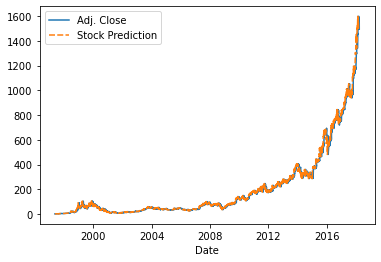

In [5]:
'''CREATE A VARIABLE TO STORE THE NUMBER OF DAYS OUT TO PREDICT
    - FOR THIS WE USE 15 DAYS
    - CAN BE CHANGED TO ANY AMOUNT'''
nday = 15 

'''SINCE WE ARE DOING A PREDICTIVE ANALYSIS, CREATE A NEW COLUMN TO STORE THE TARGET PREDICTION'''
amazon_df['Stock Prediction'] = amazon_df[['Adj. Close']].shift(-nday)

'''SHOW OUR DATAFRAME'''
print(f"Showing the amazon_df.head()\n \n {amazon_df.head()}")
print()
print(f"Showing the amazon_df.tail()\n \n {amazon_df.tail()}")
sns.lineplot(data = amazon_df)

In [26]:
'''READ CSV FILE CONTAINING AMAZON AVERAGE SENTIMENT'''
csv_data = pd.read_csv('AMZN_avg_sent.csv')
csv_data.head()

dates = []
for i in csv_data['date']:
    dates.append(datetime.strptime(i, '%m/%d/%y'))

#convert sentiment datafram to match format of main_df so they can be joined on date
dates = np.array((dates))
dates = pd.DataFrame(dates)
dates.set_index(0)
csv_data['dates'] = dates
csv_data = csv_data[['sent', 'dates']]
csv_data = csv_data.set_index('dates')
amazon_df = amazon_df.join(csv_data, how='inner')
amazon_df.head()

ValueError: columns overlap but no suffix specified: Index(['sent'], dtype='object')

Numpy Array 
 [[   1.72916667]
 [   1.70833333]
 [   1.63583333]
 ...
 [1500.25      ]
 [1523.61      ]
 [1537.64      ]]


<AxesSubplot:>

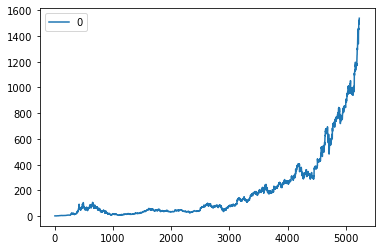

In [6]:
'''CREATE A NEW *INDEPENDENT* DATASET TO TRAIN LINEAR REGRESSION MODEL
    1. CONVERT DATAFRAME TO NUMPY ARRAY USING ONLY Adj. Close COLUMN
    2. REMOVE LAST N NUMBER OF ROWS'''
#1.
x_data = np.array(amazon_df.drop(['Stock Prediction'], 1))
#2.
x_data = x_data[:-nday]


print(f"Numpy Array \n {x_data}")
sns.lineplot(data = x_data)

Target Data 
 [1.68750000e+00 1.58333333e+00 1.54166667e+00 ... 1.49556000e+03
 1.55586000e+03 1.49705000e+03]


<AxesSubplot:>

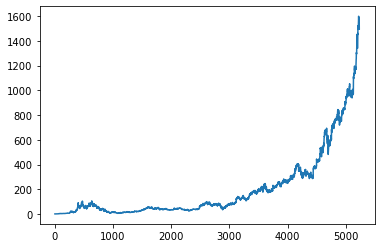

In [7]:
'''CREATE THE NEW *DEPENDENT* DATASET -- AKA THE TARGET DATA
    1. CONVERT DATAFRAME TO NUMPY ARRAY FROM Stock Prediction COLUMN
    2. REMOVE THE LAST N NUMBER OF ROWS
    3. MAKE SURE THERE ARE NO NaN VALUES'''
#1
y_data = np.array(amazon_df['Stock Prediction'])

#2
y_data = y_data[:-nday]

#3
print(f"Target Data \n {y_data}")
sns.lineplot(data = y_data)

In [8]:
'''SET UP OUR TRAIN TEST SPLIT
    - x_data, y_data --> datasets we are using
    - test_size is split to 80% training and 20% testing'''

'''TESTING DATA IS SET -- MOVE ON TO THE MODELS'''
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.2)

In [9]:
'''CREATE SUPPORT VECTOR MACHINE (REGRESSION) MODEL
    - MODEL ATTEMPTS TO PREDICT A STOCK PRICE IN THE FUTURE
    
    1. USING 3 PARAMETERS
        - KERNEL (TYPE OF MATHEMATICAL FUNCTION TO USE)
            - USING RBF FOR THIS MODEL -- RADIAL BASIS FUNCTION -- GAUSSIAN FUNCTION
            - https://scikit-learn.org/stable/modules/svm.html
            - https://www.cs.princeton.edu/sites/default/files/uploads/saahil_madge.pdf
            
        - C
            - HELPS WITH THE MISCLASSIFICATION OF TRAINING EXAMPLES
            - CHOOSING A LOW INT CREATES A SMOOTH DECISION
            - CHOOSING A HIGH INT CREATES THE CLASSIFICATION OF DATA MORE ACCURATELY
            
        - GAMMA
            - DECIDING FACTOR OF HOW MUCH INFLUENCE A SINGLE TRAINING EXAMPLE HAS
            
        - USED THE FOLLOWING TO CORRECTLY CHOOSE A PROPER C AND GAMMA VALUES
            - https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV
        
    2. THEN REFIT THE DATA WITH THE SVM MACHINE USING .fit()
        - .fit(1, 2)
            - 1 --> TRAINING VECTOR WHERE N SAMPLES IS THE NUMBER OF SAMPLES
            - 2 --> TARGET IS RELATIVE TO X FOR REGRESSION
            
    '''

#1
svr_machine = SVR(kernel = 'rbf', C = 1e3, gamma = 0.1)

#2
svr_machine.fit(x_train, y_train)

SVR(C=1000.0, gamma=0.1)

In [10]:
'''GET THE SCORE OF THE SVM MODEL -- REGRESSION
    1. SCORE Returns the coefficient of determination R^2 of the prediction.
        - BEST POSSIBLE SCORE IS 1.0 -- CAN BE NEGATIVE
        - .score(1, 2) PARAMETERS
            - 1 --> TRAINING VECTOR WHERE N SAMPLES IS THE NUMBER OF SAMPLES
            - 2 --> TARGET IS RELATIVE TO X FOR REGRESSION'''


#1
SVM_score = svr_machine.score(x_test, y_test)


print(f"SVM (Regression)  Confidence: {SVM_score}")

SVM (Regression)  Confidence: 0.9589305379035706


In [11]:
'''1. CREATE LINEAR REGRESSION MODEL
   2. TRAIN MODEL'''

#1
lnr = LinearRegression()

#2
lnr.fit(x_train, y_train)

LinearRegression()

In [12]:
'''GET THE SCORE OF THE LINEAR REGRESSION MODEL
        1. SCORE Returns the coefficient of determination R^2 of the prediction.
        - BEST POSSIBLE SCORE IS 1.0 -- CAN BE NEGATIVE
        - .score(1, 2) PARAMETERS
            - 1 --> TRAINING VECTOR WHERE N SAMPLES IS THE NUMBER OF SAMPLES
            - 2 --> TARGET IS RELATIVE TO X FOR REGRESSION'''

#1
lnr_confidence = lnr.score(x_test, y_test)



print(f"Linear Confidence: {lnr_confidence}")
print('Since model score is so close to 1, it is better to predict the Amazon Stock price.')

Linear Confidence: 0.993613439480028
Since model score is so close to 1, it is better to predict the Amazon Stock price.


In [13]:
'''MODELS ARE TRAINED AND TESTED -- TIME FOR PREDICTIONS

    1. CREATE A NEW NUMPY ARRAY BY DROPPING THE STOCK PREDICTION AND ADDING IN OUR N DAYS OUT FROM THE BEGINNING
    2. PRED
        - DATA TO BE USED TO MAKE PREDICTIONS

    '''
#1
pred = np.array(amazon_df.drop(['Stock Prediction'], 1))[-nday:]




print(pred)

[[1545.  ]
 [1551.86]
 [1578.89]
 [1598.39]
 [1588.18]
 [1591.  ]
 [1582.32]
 [1571.68]
 [1544.93]
 [1586.51]
 [1581.86]
 [1544.1 ]
 [1495.56]
 [1555.86]
 [1497.05]]


In [14]:
'''PRINT PREDICTIONS FOR BOTH MODELS USING .predict()
    - THIS WILL PERFORM CLASSIFICATION ON SAMPLES IN OUR X_DATA'''

'''LINEAR REGRESSION PREDICTION'''
lnr_prediction = lnr.predict(pred)
print('Linear Regression Model Prediction Prices -- 15 days out')
for i in lnr_prediction:
    print(f"Stock Price: ${i}")
print()

'''SUPPORT VECTOR MACHINE PREDICTION'''
SVM_prediction = svr_machine.predict(pred)
print('Support Vector Machine (Regression) Prediction Prices -- 15 days out')
for i in SVM_prediction:
    print(f"Stock Price: ${i}")



Linear Regression Model Prediction Prices -- 15 days out
Stock Price: $1591.2223114012104
Stock Price: $1598.2942082453135
Stock Price: $1626.1591312330845
Stock Price: $1646.2614619123865
Stock Price: $1635.7360877464546
Stock Price: $1638.6431940293073
Stock Price: $1629.695079655136
Stock Price: $1618.7264233255066
Stock Price: $1591.1501491885156
Stock Price: $1634.014503529304
Stock Price: $1629.220870828855
Stock Price: $1590.294511523704
Stock Price: $1540.2551714635338
Stock Price: $1602.4177632564522
Stock Price: $1541.7911957051829

Support Vector Machine (Regression) Prediction Prices -- 15 days out
Stock Price: $693.0283563258415
Stock Price: $689.4425191299359
Stock Price: $689.4425177953476
Stock Price: $689.4425177953476
Stock Price: $689.4425177953476
Stock Price: $689.4425177953476
Stock Price: $689.4425177953476
Stock Price: $689.4425177953476
Stock Price: $693.4156007110864
Stock Price: $689.4425177953476
Stock Price: $689.4425177953476
Stock Price: $701.880966115453

**RESOURCCES THAT HELPED ME**

1. https://www.analyticsvidhya.com/blog/2017/09/understaing-support-vector-machine-example-code/
2. https://towardsdatascience.com/introduction-to-linear-regression-in-python-c12a072bedf0
3. https://www.quora.com/How-do-I-select-SVM-kernels
4. https://www.cs.princeton.edu/sites/default/files/uploads/saahil_madge.pdf
5. https://journalofbigdata.springeropen.com/articles/10.1186/s40537-020-00333-6
6. https://www.researchgate.net/post/Diffference_between_SVM_Linear_polynmial_and_RBF_kernel
7. https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV
8. https://scikit-learn.org/stable/modules/svm.html

